# Задание No4  


В этом задании вам предстоит классифицировать типы соевых бобов
(http://archive.ics.uci.edu/ml/datasets/Soybean+%28Large%29).
В рамках этого задания вам необходимо сделать следующее:
1. Сделать EDA для ваших данных (5 баллов):
– проанализируйте какие переменные есть, возможно стоит построить графики
– проверить наличие NA, что с ними сделать – на ваше усмотрение
– проверить наличие скоррелированных переменных в ваших данных, визуализируйте
это, за вами выбор оставить эти переменные или нет.
2. Разделите ваш датасет на тестовую и тренировочную выборки в таком отношении, что бы
все классы были представлены в обоих выборках и были стратифицированны (равное
распределение классов, нужно указать доп. опцию в фунции train_test_split) (2
балла).
3. Обучите ваш классификатор (предлагаю воспользоваться методом RandomForestClassifier)
на вашей обучающей выборке (2 балла).
4. В случае тестовой выборки удалите информацию о принадлежности к классам (1 балл).
5. Предскажите значения классов используя ваш классификатор (2 балла).
6. Оцените качество вашего классификатора используя известные вам метрики (F-мера и мера и
матрица неточностей). Какие выводы вы можете сделать (5 баллов).
7. Выведите топ-мера и 3 признаков, которые оказались самыми важными при классификации (2
балла).
8. С помощью GridSearch оптимизируйте ваш классификатор и сравните его с полученным
изначально (4 баллов).

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import scipy.stats as ss
import warnings
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

%matplotlib inline

In [4]:
data = pd.read_csv("/home/tsaralex/Documents/Bioinf/BI_2019_stat_R/soybean-large_data.csv")
data.columns

Index(['name', 'date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist',
       'area-damaged', 'severity', 'seed-tmt', 'germination', 'plant-growth',
       'leaves', 'leafspots-halo', 'leafspots-marg', 'leafspot-size',
       'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem', 'lodging',
       'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external decay',
       'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit spots',
       'seed', 'mold-growth', 'seed-discolor', 'seed-size', 'shriveling',
       'roots'],
      dtype='object')

Видим, колонку date, которую использовать для классификатора вряд ли стоит. 

In [5]:
data.drop('date',axis=1,inplace=True)

In [6]:
# проверим на наличие NA - их нет (по крайней мере вот так сразу если посмотреть)
not all(data.isnull().sum())

True

В описании к датасету видим, что в данных есть значения "?",что означает - "An unknown values", что можно интерпретировать как NA. Попробуем посчитать сколько таких значений есть в колонках. 

In [7]:
[data[column].replace(str("?"),np.nan,inplace=True) for column in data.columns][0]

In [8]:
# теперь появилось куда больше NaN
data.isnull().sum()

name                0
plant-stand         8
precip             11
temp                7
hail               41
crop-hist           1
area-damaged        1
severity           41
seed-tmt           41
germination        36
plant-growth        1
leaves              0
leafspots-halo     25
leafspots-marg     25
leafspot-size      25
leaf-shread        26
leaf-malf          25
leaf-mild          30
stem                1
lodging            41
stem-cankers       11
canker-lesion      11
fruiting-bodies    35
external decay     11
mycelium           11
int-discolor       11
sclerotia          11
fruit-pods         25
fruit spots        35
seed               29
mold-growth        29
seed-discolor      35
seed-size          29
shriveling         35
roots               7
dtype: int64

In [164]:
# попробуем дропнуть все NaN и посмотреть размерность датафрейма 
print(f'{np.around(data.dropna().shape[0]/data.shape[0],3)*100} % of data is remained')

86.6 % of data is remained


в итоге осталось ~86.6% данных, что может быть не так критично, но нужно посмотреть на представительность классов 

In [10]:
print('Raw dataset','\n'*2,data.name.value_counts(),'\n'*2)
print('Cropped dataset','\n'*2,
      data.dropna().name.value_counts())

Raw dataset 

 phytophthora-rot               40
frog-eye-leaf-spot             40
alternarialeaf-spot            40
brown-spot                     40
brown-stem-rot                 20
anthracnose                    20
powdery-mildew                 10
bacterial-pustule              10
charcoal-rot                   10
bacterial-blight               10
diaporthe-stem-canker          10
purple-seed-stain              10
phyllosticta-leaf-spot         10
rhizoctonia-root-rot           10
downy-mildew                   10
cyst-nematode                   6
diaporthe-pod-&-stem-blight     6
herbicide-injury                4
2-4-d-injury                    1
Name: name, dtype: int64 


Cropped dataset 

 brown-spot                40
alternarialeaf-spot       40
frog-eye-leaf-spot        40
brown-stem-rot            20
anthracnose               20
phytophthora-rot          16
powdery-mildew            10
rhizoctonia-root-rot      10
phyllosticta-leaf-spot    10
purple-seed-stain         10
di

стало даже лучше, так как предсказывать классы в которых есть очень мало наблюдений - нехорошее занятие. Такой результат совпал с тем, что написано в описании к данным:  

There are 19 classes, only the first 15 of which have been used in prior work. The folklore seems to be that the last four classes are unjustified by the data since they have so few examples.

In [11]:
data_cropped = data.dropna()

In [12]:
not all(data_cropped.isnull().sum()) # проверяем финально, остались ли NaN, все ок

True

Теперь посмотрим, как коррелируют наши переменные друг с другом. Так как все переменные у нас категориальные, нужно использовать соответствующий коэф. корреляции. Они небинарные, так что коэф корреляции Мэтьюса не подойдет, так что будет брать коэффициент корреляции V Крамера. Есть готовая функция для данного теста и взята была [отсюда](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

In [69]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# собираем матрицу корреляций
def corr_matrix_combine(dataset):
    rows = []
    for var1 in dataset:
        col = []
        for var2 in dataset:
            cramers =cramers_v(dataset[var1], dataset[var2]) # Cramer's V test
            col.append(round(cramers,2)) 
        rows.append(col)
        cramers_results = np.array(rows)
    cor_matrix = pd.DataFrame(cramers_results, columns = dataset.columns, index =dataset.columns)
    return cor_matrix

cor_matrix = corr_matrix_combine(data_cropped)

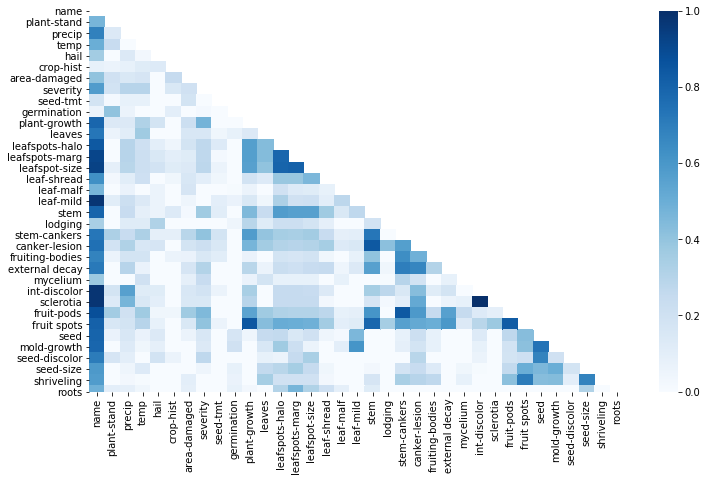

In [70]:
# визуализация 
plt.subplots(figsize=(12,7))
mask = np.zeros_like(cor_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(cor_matrix, mask=mask,vmin=0., vmax=1,cmap = 'Blues')
plt.show()

Видим несколько паттернов. 
1. переменная sclerotia имеет высокую корреляцию с переменной int-discolor. есть и другие скоррелированые перменнные но с более низкими значениями корреляции. 
2. в первом столбце все фичи так тем или иным значением коррелируют с переменной name, которую мы собираемся предсказывать; все кроме трех переменных crop-hist, seed-tmt, germination. давайте посмотрим на их значения корреляции по ближе.

In [18]:
cor_matrix.query('name < 0.2').loc[:,'name']

crop-hist      0.08
seed-tmt       0.18
germination    0.06
Name: name, dtype: float64

Видим, что эти переменные почти никак не связаны с переменной, которую мы будем предсказывать (name). Но удалять их рано, они не связаны с переменной класса, который мы предсказываем линейно, но в нелинейной зависимости, они могут быть ключевыми, так что оставим их. 
 
 
Теперь нужно решить, как быть с переменными, которые коррелируют между собой. Таких мало. Более того, в нашем случае мы используем алгоритм Random Forest, и наличие таких переменных нам некритично (а было бы критично например для наивного Байеса). Кроме того перед нами не стоит задачи сократить количество переменных на вход, поэтому будем использовать все.

In [81]:
X = data_cropped.drop("name",axis=1)
y = data_cropped.name

In [108]:
# делим данные на тренировчную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

Сразу будем искать лучшие параметры для классификтора. Кросс валидация будет leave-one-out, так как некоторых классов у нас после разделения на тестовую и тренировочную выборку осталось очень мало.

In [127]:
params_grid = {'max_depth':list(range(2,20))} 
rf = RandomForestClassifier(n_estimators=100)
loocv = LeaveOneOut()
grid_clf = GridSearchCV(estimator=rf, param_grid=params_grid, cv=loocv)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(), error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
       

In [162]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)

0.8820224719101124
{'max_depth': 7}


In [132]:
best_rf = grid_clf.best_estimator_
best_rf.score(X_test,y_test)
y_pred = best_rf.predict(X_test)
# выводим метрики качества классификатора
print(metrics.classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

   alternarialeaf-spot       0.67      0.92      0.77        13
           anthracnose       1.00      1.00      1.00         7
      bacterial-blight       1.00      1.00      1.00         3
     bacterial-pustule       1.00      1.00      1.00         3
            brown-spot       0.80      0.92      0.86        13
        brown-stem-rot       1.00      1.00      1.00         7
          charcoal-rot       1.00      1.00      1.00         3
 diaporthe-stem-canker       1.00      1.00      1.00         3
          downy-mildew       1.00      1.00      1.00         4
    frog-eye-leaf-spot       1.00      0.54      0.70        13
phyllosticta-leaf-spot       1.00      0.67      0.80         3
      phytophthora-rot       1.00      1.00      1.00         5
        powdery-mildew       1.00      1.00      1.00         3
     purple-seed-stain       1.00      1.00      1.00         4
  rhizoctonia-root-rot       1.00      

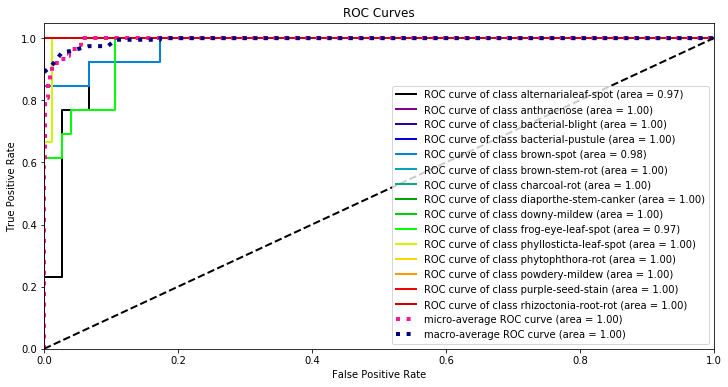

In [140]:
# Визуализация
y_probas = best_rf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_probas,figsize=[12,6])
plt.show()

В целом получился неплохой классификатор в целом (macro averaging) так и для каждого класса. Хтя для нескольких классов точность (Alternaria leaf spot) или recall (frog-eye-leaf-spot,phyllosticta-leaf-spot) не очень хорошие. Также важно помнить, что 4 класса пришлось выкинуть из-за недостаточного количества наблюдений по ним. 

Теперь выводим топ-3 важных признака для классификации.

In [159]:
def feature_imp_exctraction(clf,X):
    feat_imp_data = pd.DataFrame({'feauture':X.columns,\
                              'importance':pd.array(clf.feature_importances_)})
    feat_imp_data = feat_imp_data.sort_values('importance',ascending=False)
    feat_imp_data.importance = np.around(feat_imp_data.importance,decimals=4)
    feat_imp_data
    return feat_imp_data

In [181]:
feature_imp_exctraction(best_rf,X).iloc[:3,] # топ 3 признака для классификации болезней сои

,feauture,importance
26,fruit-pods,0.0704
27,fruit spots,0.0691
13,leafspot-size,0.0684


можно подумать, какие признаки нужно собирать, чтобы за меньшие затраты различать болезни сои

In [189]:
# посмотрим какие признаки являются самыми важными в классификации болезней (посмотрим топ-5)
feature_imp_exctraction(best_rf,X).iloc[:5,]

,feauture,importance
26,fruit-pods,0.0704
27,fruit spots,0.0691
13,leafspot-size,0.0684
19,stem-cankers,0.0586
20,canker-lesion,0.0569


Признаки топ-5 важности: нормальный вид стручков, пятна на плодах (что неудивительно, разные болезни по разному оставляют пятна), размер пятен, наличие язв и некроз.